# Day 2: Supply I

We talked today about how electricity markets work.

We will learn today how to build a simple model of an electricity market using **JuMP**.

The data and code are based on the paper "The Efficiency and Sectoral Distributional Implications of Large-Scale Renewable Policies," by Mar Reguant.


We first load relevant libraries.

Compared to day 1, we will be adding the libraries `JuMP` and the non-linear solver `Ipopt`. We will also be using the clustering library `Clustering` and the package `Random` to control the randomness in the machine learning algorithm.

**Note:** I often prefer to use commercial solvers (Gurobi or CPLEX), which are available under an academic license. I use solvers that are readily available here without a license for simplicity and to ensure that everyone can access the code.


In [1]:
#using Pkg
#Pkg.add([ "StatsPlots","StatsBase","Clustering","Random","JuMP","Ipopt","Printf"])

using DataFrames
using CSV
using Plots
using StatsPlots
using Statistics, StatsBase
using Clustering
using Random
using JuMP
using Ipopt
using Printf
using FixedEffectModels
	


We load the data using the CSV syntax (`CSV.read`) into a data frame called `df`.  Here we need to do some cleaning of the variables, rescaling and dropping missing entries.

Having a clean dataset will be very helpful for the clustering algorithm, which requires complete rows of data.


In [22]:
# We read the data and clean it up a bit
df = CSV.read("data_jaere.csv", DataFrame)
df

Row,year,month,day,hour,price,nuclear,imports,hydro,q_commercial,q_industrial,q_residential,wind_cap,solar_cap
,Int64,Int64,Int64,Int64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,2013,1,1,1,33.3462,missing,missing,missing,8404.45,2305.65,12233.9,missing,missing
2,2011,1,1,1,32.7882,missing,missing,missing,8785.25,2097.89,11863.9,missing,missing
3,2014,1,1,1,45.1549,missing,missing,missing,8370.06,2365.63,11337.3,missing,missing
4,2012,1,1,1,28.0765,missing,missing,missing,8626.71,1952.2,11112.1,missing,missing
5,2015,1,1,1,35.5547,missing,missing,missing,8440.56,2425.18,12640.3,missing,missing
6,2011,1,1,2,29.1801,missing,missing,missing,8661.71,2099.24,11020.0,missing,missing
7,2013,1,1,2,31.4164,missing,missing,missing,8311.4,2267.49,11387.1,missing,missing
8,2015,1,1,2,33.5682,missing,missing,missing,8432.7,2430.04,11816.3,missing,missing
9,2012,1,1,2,22.4694,missing,missing,missing,8528.95,1938.49,10199.6,missing,missing


In [30]:
df = sort(df,["year","month","day","hour"])
df = dropmissing(df)
df.nuclear = df.nuclear/1000.0
df.hydro = df.hydro/1000.0
df.imports = df.imports/1000.0
df.q_commercial = df.q_commercial/1000.0
df.q_industrial = df.q_industrial/1000.0
df.q_residential = df.q_residential/1000.0
df.hydronuc = df.nuclear + df.hydro 
df = select(df,Not(["nuclear","hydro"]))


Row,year,month,day,hour,price,imports,q_commercial,q_industrial,q_residential,wind_cap,solar_cap,hydronuc
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2011,1,2,1,29.5397,4.502,8.38001,2.05659,10.6404,0.019787,0.0,6.558
2,2011,1,2,2,27.9688,4.363,8.34789,2.06558,9.80354,0.0221706,0.0,6.455
3,2011,1,2,3,26.5258,4.089,8.54809,2.11851,9.5554,0.0269027,0.0,6.453
4,2011,1,2,4,25.5872,3.783,8.56002,2.13467,9.31031,0.0269792,0.0,6.407
5,2011,1,2,5,25.9229,3.969,8.61251,2.17499,9.4285,0.0310433,0.0,6.564
6,2011,1,2,6,27.8414,4.141,8.81962,2.23299,9.73939,0.0369689,0.0,6.674
7,2011,1,2,7,27.8229,4.381,8.78951,2.29248,10.403,0.0340186,0.0611576,6.959
8,2011,1,2,8,28.093,4.74,8.24397,2.30747,11.6536,0.0323264,0.140097,6.788
9,2011,1,2,9,30.9623,5.298,8.09124,2.30744,13.0393,0.0330962,0.223541,7.034


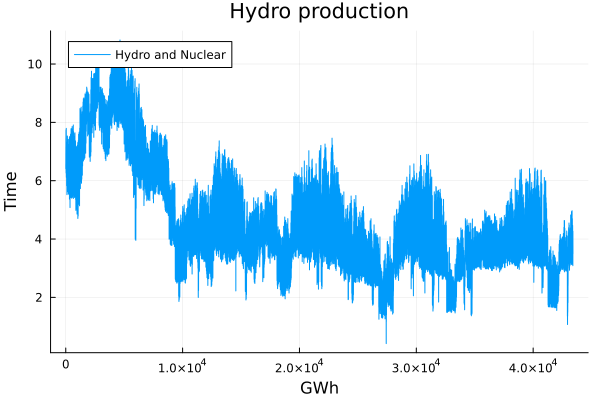

In [33]:
plot(rownumber.(eachrow(df)),df.hydronuc, label="Hydro and Nuclear", xlabel="GWh", ylabel="Time", title="Hydro production", legend=:topleft)

## Clustering

When modeling electricity markets, oftentimes the size of the problem can make the solver slow.

Here we will be using a clustering algorithm to come up with a (much) smaller synthetic dataset that we will use for the purposes of our main analysis.

**Note:** We ignore the time variables when we cluster. In our case, we'll transform a dataset of 43408 hours to 100 representatives hours. That is enough if you assume no correlation between hours.


In [4]:
# define number of clusters
n = 1000
# Clustering algorithms work in rows, so we need to transpose our data
X = transpose(Array(select(df,Between(:price,:hydronuc))));

# We scale variables to improve kmeans performance. For that, we take the mean and std of each row (dim=2) and you repeat it by the number of columns (rows in df)
Xs = (X.- repeat(mean(X,dims=2),1,nrow(df)))./repeat(std(X,dims=2),1,nrow(df)); 

#we set seed because kmeans picks random samples to generate clusters
Random.seed!(2020)
R = kmeans(Xs, n);

# Get the cluster centers rescaling again. These centers will be the new observations
M = R.centers .* repeat(std(X,dims=2),1,n) .+ repeat(mean(X,dims=2),1,n);  

# Assignments of each cluster
A = assignments(R)


43408-element Vector{Int64}:
  90
  90
  90
  90
  90
  90
  90
  90
 468
 167
   ⋮
 409
 837
 851
 851
 851
 912
 912
 836
 891

In [5]:
dfclust = DataFrame(transpose(M),
	["price", "imports", "q_commercial", "q_industrial", "q_residential", 
			"wind_cap", "solar_cap", "hydronuc"]);
    # the weights is defined by the number of old observations assigned to each cluster          
	dfclust.weights = counts(R);
	first(dfclust, 5)
	

Row,price,imports,q_commercial,q_industrial,q_residential,wind_cap,solar_cap,hydronuc,weights
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,42.7844,7.84933,15.0171,6.20885,8.57687,0.502497,0.806817,4.36165,63
2,49.8722,9.15263,11.6964,4.07283,12.3225,0.29044,0.00818897,4.64345,60
3,42.3743,8.65655,12.5901,5.33423,16.8024,0.616442,0.0236323,5.41473,44
4,24.9578,7.2867,9.55949,3.65599,7.43176,0.722925,0.000873883,3.46457,86
5,39.7033,5.69879,10.8799,3.70093,9.61579,0.226178,0.32164,2.50333,66


We can compare the distribution of outcomes between the original dataset and the new dataset.

Here is an example with prices. The two distributions are very similar.


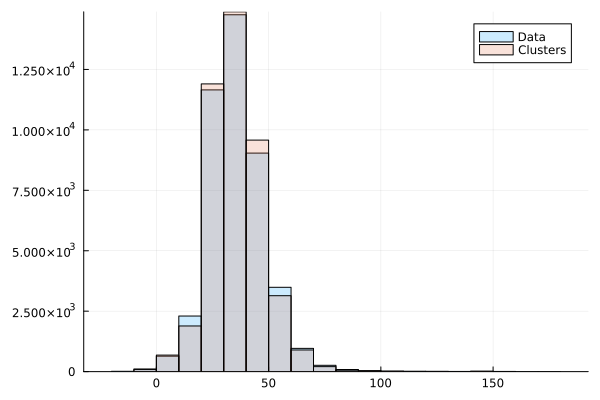

In [6]:
histogram(df.price, fillalpha=.2, nbins=20, label="Data")
	histogram!(dfclust.price,weights=dfclust.weights, 
	fillalpha=.2, nbins=20, 
		label="Clusters")

It is also relatively well matched for the case for solar, although it is harder there.


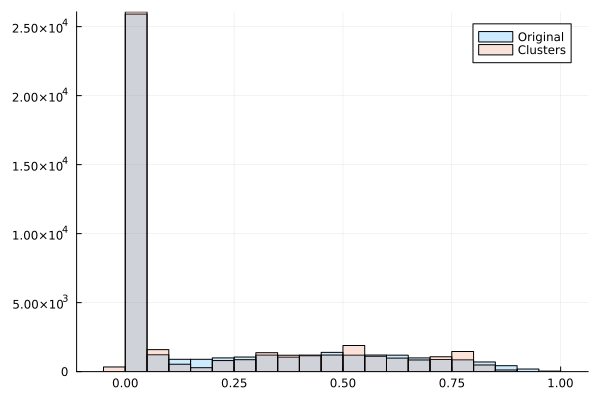

In [7]:
histogram(df.solar_cap, fillalpha=.2, nbins=20, label="Original")
	histogram!(dfclust.solar_cap, weights=dfclust.weights, fillalpha=.2, nbins=20, label="Clusters")

### Saving the output

It is useful to save the clustered data so that we can use it directly.


In [8]:
CSV.write("data_jaere_clustered.csv", dfclust)


"data_jaere_clustered.csv"

## Building the model

Now that we have clustered our data, we will build our model with the data that we have. 

The model that we will build today is a simplification from the original paper.

In the original paper, the model needed to solve for:
1. Endogenous retail prices (in a demand model, iterated to find equilibrium)
2. Endogenous investment (in same supply model, with more equations)

Here we will be simply building a simple model of market clearing.


Before building the model, we define some model parameters related to:

* Number and costs of different technologies (loaded from a small dataset)

* Elasticity of demand and imports


In [9]:
tech = CSV.read("data_technology_simple.csv", DataFrame)


Row,techname,heatrate,heatrate2,capUB,thermal,e,e2,c,c2
,String15,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64
1,Hydro/Nuclear,10.0,0.0,1.0,0,0.0,0.0,10.0,0.0
2,Existing 1,6.67199,0.0929123,11.5,1,0.360184,0.0048861,23.352,0.325193
3,Existing 2,9.79412,0.286247,14.5,1,0.546134,0.0110777,34.2794,1.00187
4,Existing 3,13.8181,20.5352,0.578,1,0.816768,0.234476,48.3634,71.8731
5,Wind,0.0,0.0,100.0,0,0.0,0.0,0.0,0.0
6,Solar,0.0,0.0,100.0,0,0.0,0.0,0.0,0.0


Here we assume zero marginal costs for renewable energy. `capUB` defines the maximum capacity of each power plant. For the existing ones, it defines the maximum production. For renewables, they will always produce at maximum capacity (precisely because of zero marginal costs) but production will depend on the capacity factors defined before.

To calibrate demand, one can use different strategies. Here we compute the slope for the demand curve that is consistent with the assumed elasticity of demand. 

Notice that this is a local elasticity approximation, but it has the advantage of being a linear demand curve, which is very attractive for the purposes of linear programming.

The demand is: $ q = a - b \ p $

So the elasticity becomes: $elas =  b  \frac{p}{q} $, which we set equal to an assumed parameter.

Once we have $b$, we can back out $a$. 

An analogous procedure is done for imports, but in this case, $ qm = am + bm \ p $


In [10]:
minimum(dfclust.price), minimum(dfclust.imports)

(-0.8200677328117578, 2.4448333333333334)

In [32]:
reg(df, @formula(log(imports+1) ~ log(price+1.0) + fe(year) + fe(month) + fe(day) + fe(hour)), Vcov.cluster(:hour))

DomainError: DomainError with -0.003270000000000106:
log was called with a negative real argument but will only return a complex result if called with a complex argument. Try log(Complex(x)).

In [12]:
dfclust.weights = dfclust.weights / sum(dfclust.weights);
	
	# Here only one demand type to make it easier
	dfclust.demand = dfclust.q_residential + dfclust.q_commercial + dfclust.q_industrial;
	
    # Calibrate demand based on elasticities (using 0.1 here as only one final demand)
	elas = [.1, .2, .5, .3];
	dfclust.b = elas[1] * dfclust.demand ./ dfclust.price;  # slope
	dfclust.a = dfclust.demand + dfclust.b .* dfclust.price;  # intercept

	# Calibrate imports (using elas 0.3)
    dfclust.bm = elas[4] * dfclust.imports ./ dfclust.price;  # slope
    dfclust.am = dfclust.imports - dfclust.bm .* dfclust.price;  # intercept

In [13]:
mean(dfclust.bm, weights=dfclust.weights)

MethodError: MethodError: no method matching mean(::Vector{Float64}; weights::Vector{Float64})

Closest candidates are:
  mean(::AbstractArray, !Matched::UnitWeights; dims) got unsupported keyword argument "weights"
   @ StatsBase ~/.julia/packages/StatsBase/ebrT3/src/weights.jl:687
  mean(::AbstractArray, !Matched::AbstractWeights; dims) got unsupported keyword argument "weights"
   @ StatsBase ~/.julia/packages/StatsBase/ebrT3/src/weights.jl:680
  mean(::AbstractArray; dims) got unsupported keyword argument "weights"
   @ Statistics ~/.julia/juliaup/julia-1.10.4+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/Statistics/src/Statistics.jl:174
  ...


### Non-linear solver

We are now ready to clear the market. We will **maximize welfare** using a non-linear solver.

$ \max \ CS - Costs $

$ \text{s.t.} \ \text{operational constraints, market clearing}. $


In [14]:
function clear_market_max(data::DataFrame, tech::DataFrame; 
    wind_gw = 5.0, solar_gw = 2.0)

# We declare a model
model = Model(
    optimizer_with_attributes(
        Ipopt.Optimizer)
    );

# Set useful indexes
I = nrow(tech);  # number of techs
T = nrow(data);  # number of periods
S = 1;  # we will only be using one sector to keep things simple

# Variables to solve for
@variable(model, price[1:T]);
@variable(model, demand[1:T]);
@variable(model, imports[1:T]);
@variable(model, quantity[1:T, 1:I] >= 0);
@variable(model, CS[1:T]);
@variable(model, PC[1:T]);
@variable(model, IC[1:T]);

# Maximize welfare including imports costs
@NLobjective(model, Max, sum(data.weights[t] * (CS[t] - PC[t] - IC[t] for t=1:T)));

# Auxiliary Variables
@constraint(model, [1:T], CS[t] ==  (data.a[t] - demand[t]) * demand[t] / data.b[t] + demand[t]^2/(2*data.b[t]));
@constraint(model, [1:T], PC[t] ==  sum(tech.c[i] * quantity[t,i] + tech.c2[i] * quantity[t,i]^2/2 for i=1:I));
@constraint(model, [1:T], IC[t] == (imports[t] - data.am[t])^2/(2 * data.bm[t]));

# Market clearing
@constraint(model, [t=1:T], 
    demand[t] == data.a[t] - data.b[t] * price[t]);
@constraint(model, [t=1:T], 
    imports[t] == data.am[t] + data.bm[t] * price[t]);
@constraint(model, [t=1:T], 
    demand[t] == sum(quantity[t,i] for i=1:I) + imports[t]);

# Constraints on output
@constraint(model, [t=1:T], 
    quantity[t,1] <= data.hydronuc[t]);	
@constraint(model, [t=1:T,i=2:3], 
    quantity[t,i] <= tech[i,"capUB"]);
@constraint(model, [t=1:T], 
    quantity[t,5] <= wind_gw * data.wind_cap[t]);
@constraint(model, [t=1:T], 
    quantity[t,6] <= solar_gw * data.solar_cap[t]);

# Solve model
optimize!(model);

status = @sprintf("%s", JuMP.termination_status(model));

if (status=="LOCALLY_SOLVED")
    p = JuMP.value.(price);
    avg_price = sum(p[t] * data.weights[t] for t=1:T);
    q = JuMP.value.(quantity);
    imp = JuMP.value.(imports);
    d = JuMP.value.(demand);
    cost = sum(data.weights[t] * (sum(tech.c[i] * q[t,i] 
            + tech.c2[i] * q[t,i]^2 / 2 for i=1:I) 
            + (imp[t] - data.am[t])^2/(2 * data.bm[t])) for t=1:T);
    results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)),
        "avg_price" => avg_price,
        "price" => p,
        "quantity" => q,
        "imports" => imp,
        "demand" => d,
        "cost" => cost);
    return results
else
    results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)));
    return results
end

end

LoadError: LoadError: Unsupported generator `:*`
in expression starting at /Users/marreguant/Documents/GitHub/phd-energy/materials/day2/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X34sZmlsZQ==.jl:25

In [15]:
results = clear_market_max(dfclust, tech)


UndefVarError: UndefVarError: `clear_market_max` not defined

In [16]:
results["avg_price"]

UndefVarError: UndefVarError: `results` not defined

We can study the effects of an increase in renewable capacity

In [17]:
results = clear_market_max(dfclust, tech, wind_gw = 7.0, solar_gw = 3.0)

UndefVarError: UndefVarError: `clear_market_max` not defined

In [18]:
results["quantity"]

UndefVarError: UndefVarError: `results` not defined

We can see the relation between renewable production and prices

In [19]:
wind = results["quantity"][:,5]
price = results["price"]

UndefVarError: UndefVarError: `results` not defined

In [20]:
scatter(wind,price)

UndefVarError: UndefVarError: `wind` not defined

## Follow-up exercise

1. (*) The function is prepared to take several amounts of solar and wind. What are the impacts on prices as you increase solar and wind? Save prices for different values of wind or solar investment and plot them. Does your answer depend a lot on the number of clusters?
